In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D


## Problem: Travelling Salesman Problem

Given a graph $G=(V,E)$ with $N=|V|$ nodes (cities), what is the cheapest hamiltonian cycle, considering the edge $e_{i,j}$ as the cost from going from city $i$ to city $j$?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}  + M \bigg[ \sum_{i=1}^{N}  \left( 1- \sum_{t=1}^{N} x_{t, i} \right)^2 + \sum_{t=1}^{N}  \left( 1- \sum_{i=1}^{N} x_{t, i} \right)^2  \bigg]\, ,
\end{align}

and the decision variable $\{x_{t, i}\}_{i,t=1,\dots,N} \in \{0,1\}^{N^2}$ is defined as

\begin{align}
	x_{t, i} = 
    \begin{cases}
	1 & \text{if city } i \text{ is visited at time step } t \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

The constraint enforces the decision matrix $[x]_{t, i}$ to be a permutation matrix, ordering the temporal visit of each city.

- $N$: Number of cities/nodes.
- ${\rm{bits}} = N^2$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

In [2]:
### nice plots

import matplotlib as matp

matp.rcParams['mathtext.fontset'] = 'stix'
matp.rcParams['font.family'] = 'STIXGeneral'

## Read data for analysis

In [3]:
## Dataset 

colors = sns.color_palette("Paired", 12)
cases_names = {'38': ['ftv38'], '33': ['ftv33'], '42': ['dantzig42', 'swiss42'], '48': ['ry48p', 'hk48', 'gr48', 'att48'], '44': ['ftv44'], '43': ['p43'], '17': ['br17', 'gr17'], '53': ['ft53'], '21': ['gr21'], '55': ['ftv55'], '58': ['brazil58'], '14': ['burma14'], '29': ['bayg29', 'bays29'], '16': ['ulysses16'], '35': ['ftv35'], '47': ['ftv47'], '52': ['berlin52'], '22': ['ulysses22'], '26': ['fri26']}
N_cities =  list(cases_names.keys())
for i in range(len(N_cities)):
    N_cities[i] = int(N_cities[i])
N_cities = np.sort(N_cities)
print(N_cities)

n_vseeds = 1
runs = 128
vseeds = np.array([42])


class Datas():
    def __init__(self, bits_idx_list, vseed_list, n_temp_scalers, M_strats, n_eta_runs, n_samples_SA = 128):
        self.Nc = N_cities[bits_idx_list]
        self.bits = N_cities[bits_idx_list]**2
        self.M_strategies = M_strats # index: 0->"feasibility", 1->"optimality"
        self.temperature_scalers = np.array([1, 10, 100])
        self.SA_samples = 128

        self.M_star = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.M_L1 = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_required = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_guaranteed = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_effective = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.temperature = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, 2)) # last index: 0->initial, 1->final
        self.E_f = np.ndarray((len(bits_idx_list), len(vseed_list)))


[14 16 17 21 22 26 29 33 35 38 42 43 44 47 48 52 53 55 58]


In [4]:
N_idxs = np.arange(6)
n_temp_scalers = 3
M_strategies = ["feasibility", "optimality"]
n_eta_runs = 3
data = Datas(N_idxs, vseeds, n_temp_scalers, M_strategies, n_eta_runs)

directory = "../data/SA_TSP_case_righttemp/"

for N_idx in N_idxs:
    Nc = N_cities[N_idx]
    filename = directory + f"results-{cases_names[str(Nc)][0]}.txt"
    file = open(filename, "rb")
    D = pickle.load(file)
    file.close()

    assert len(D.keys()) == len(vseeds)
    for seed_idx, seed in enumerate(D):
        data.E_f[N_idx, seed_idx] = D[seed]["E_f"]

        assert len(D[seed].keys()) == n_temp_scalers + 1 # the +1 is for E_f
        for temp_idx, temp_scaler in enumerate(list(D[seed])[1:]):
            data.temperature[N_idx, seed_idx, temp_idx, 0] = D[seed][temp_scaler]["temp_initial"]
            data.temperature[N_idx, seed_idx, temp_idx, 1] = D[seed][temp_scaler]["temp_final"]

            assert len(D[seed][temp_scaler].keys()) == len(M_strategies) + 2  # the +2 is for temp_initial and temp_final
            for M_strat_idx, M_strat in enumerate(list(D[seed][temp_scaler])[2:]):
                assert len(D[seed][temp_scaler][M_strat].keys()) == n_eta_runs
                for eta_run_idx, eta_req in enumerate(D[seed][temp_scaler][M_strat]):
                    data.M_star[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["M_star"]
                    data.M_L1[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["M_L1"]
                    data.eta_required[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["eta_required"]
                    data.eta_guaranteed[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["eta_guaranteed"]
                    data.eta_effective[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_req]["eta_effective"]

## $\eta_{eff} / \eta_{guar} (\beta_f scaler)$ for different $\eta_{req}$ and feas/opt $M$ strategies

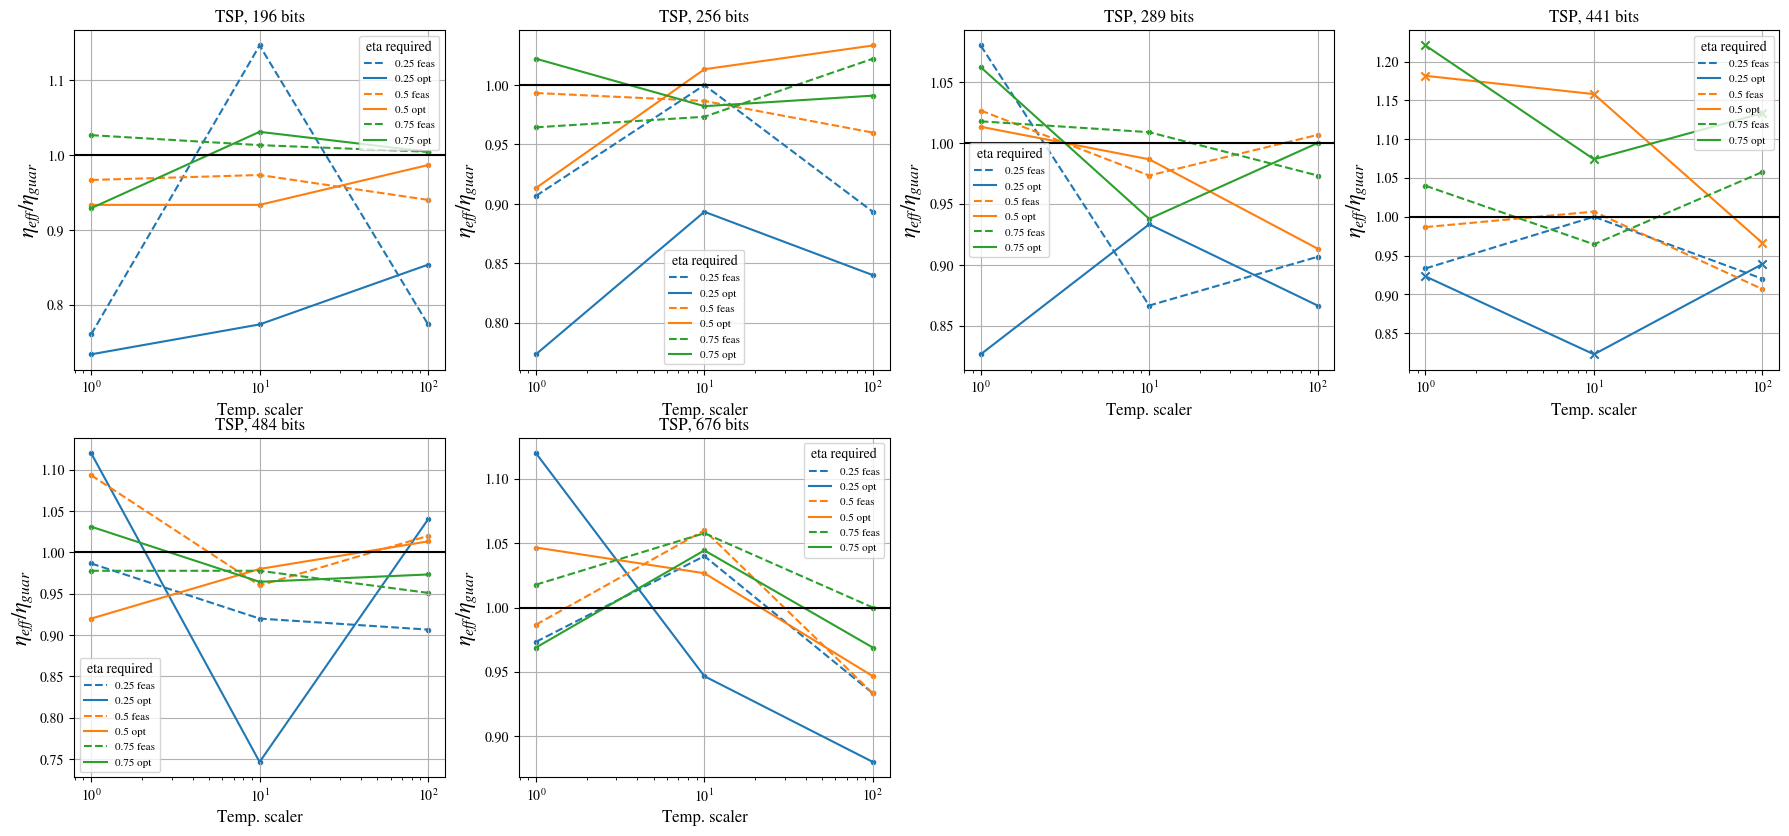

In [5]:
fig = plt.figure(figsize=(22,15))
for N_idx in N_idxs:
    ratios = np.mean( data.eta_effective[N_idx, ...] / data.eta_guaranteed[N_idx, ...] , axis = 0)
    ratios_std = np.std( data.eta_effective[N_idx, ...] / data.eta_guaranteed[N_idx, ...] , axis = 0)
    
    ax = fig.add_subplot(3,4,N_idx+1)
    ax.set_xlabel('Temp. scaler', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)


    for eta_run_idx in np.arange(n_eta_runs):
        style = ["--", "-"]
        lab = [" feas", " opt"]
        for M_strat_idx in range(2):
            ax.plot(data.temperature_scalers, ratios[:, M_strat_idx, eta_run_idx], style[M_strat_idx], color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + lab[M_strat_idx])
            guar_is_req = (data.eta_guaranteed[N_idx, 0, :, M_strat_idx, eta_run_idx] == data.eta_required[N_idx, 0, :, M_strat_idx, eta_run_idx])     # boolean mask        
            ax.scatter(data.temperature_scalers[guar_is_req], ratios[guar_is_req, M_strat_idx, eta_run_idx], marker=".", color = f"C{eta_run_idx}")
            ax.scatter(data.temperature_scalers[~guar_is_req], ratios[~guar_is_req, M_strat_idx, eta_run_idx], marker="x", color = f"C{eta_run_idx}")
    ax.set_xscale("log")
    ax.set_title(f"TSP, {N_cities[N_idx]**2} bits")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

## $\eta_{eff} / \eta_{guar} (n_{bits})$

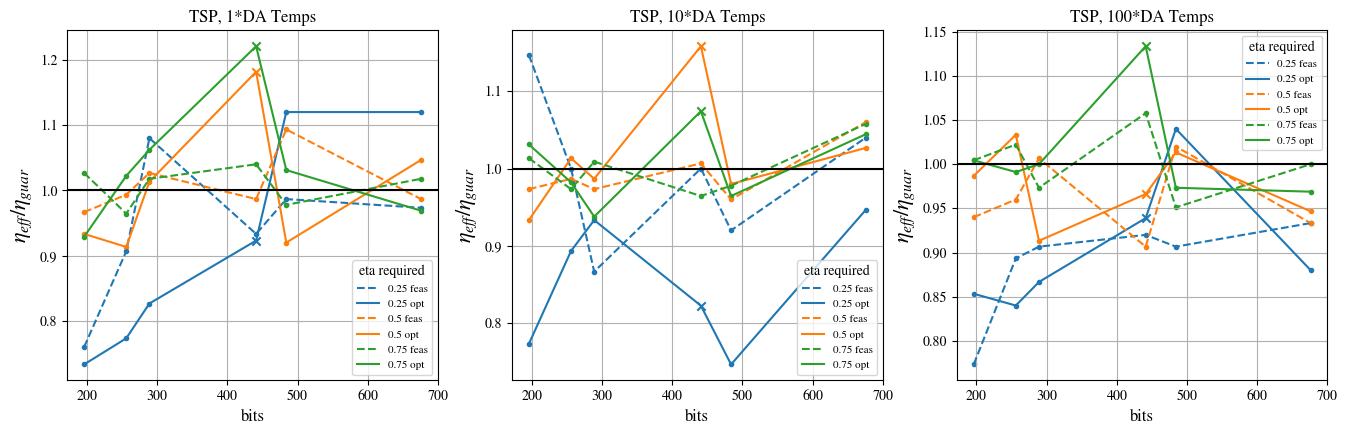

In [6]:
fig = plt.figure(figsize=(22,10))
for temp_idx in range(n_temp_scalers):
    ratios = np.mean( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    ratios_std = np.std( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    
    ax = fig.add_subplot(2,4,temp_idx+1)
    ax.set_xlabel('bits', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)

    for eta_run_idx in np.arange(n_eta_runs):
        style = ["--", "-"]
        lab = [" feas", " opt"]
        for M_strat_idx in range(2):
            ax.plot(data.bits, ratios[:, M_strat_idx, eta_run_idx], style[M_strat_idx], color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + lab[M_strat_idx])
            guar_is_req = (data.eta_guaranteed[:, 0, temp_idx, M_strat_idx, eta_run_idx] == data.eta_required[:, 0, temp_idx, M_strat_idx, eta_run_idx])     # boolean mask
            ax.scatter(data.bits[guar_is_req], ratios[guar_is_req, M_strat_idx, eta_run_idx], marker=".", color = f"C{eta_run_idx}")
            ax.scatter(data.bits[~guar_is_req], ratios[~guar_is_req, M_strat_idx, eta_run_idx], marker="x", color = f"C{eta_run_idx}")
    #ax.set_xscale("log")
    ax.set_title(f"TSP, {data.temperature_scalers[temp_idx]}*DA Temps")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

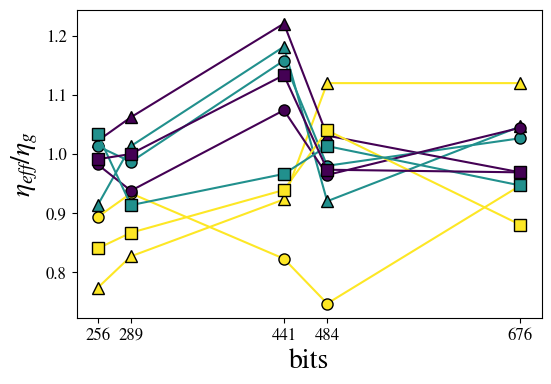

In [17]:
M_strategy = "optimality" # "feasibility" or "optimality"
if M_strategy == "feasibility":
    M_strat_idx = 0
    M_strat_short = "feas"
else:
    M_strat_idx = 1
    M_strat_short = "opt"

to_skip = 1
markers = ["^", "o", "s"]

colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, n_temp_scalers))) 

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'bits', fontsize = 20)
ax.set_ylabel(r'$\eta_{eff} / \eta_{g}$', fontsize = 20)
ax.set_xticks(data.bits)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
#ax.set_ylim(0.8, 1.15)

for temp_idx in range(n_temp_scalers):
    ratios = np.mean( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    ratios_std = np.std( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.bits[to_skip:], ratios[to_skip:, M_strat_idx, eta_run_idx], "-", marker = markers[temp_idx], markersize = 8, color = discr_colors.colors[eta_run_idx], markeredgecolor="black",
                        label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + f" ; {data.temperature_scalers[temp_idx]}")

# # ---- Concise legend ----
# eta_handles = [Line2D([0], [0], color=c, lw=2, label=f'{eta}') for c, eta in zip(discr_colors.colors, data.eta_required[0,0,0,0])]
# temp_handles = [Line2D([0], [0], color="w", markersize = 8,  markeredgecolor = "k", marker=m, lw=0, label=T) for m, T in zip(markers, data.temperature_scalers)]
# all_handles = eta_handles + temp_handles
# all_labels  = [h.get_label() for h in all_handles]
# ax.legend(handles=all_handles, labels=all_labels, title=r"      $\eta_{r}$            $T/T_{DA}$", title_fontsize=14, fontsize=13, loc="center right", ncol=2)
# # --------
#ax.legend(title = r"$\eta$ required ; $\beta$ scaler", fontsize = 10, loc='center right')
if M_strategy == "feasibility":
    ax.set_title(f"cases TSP", fontsize = "18")
plt.show()

fig.savefig(f"../plots_paper/eta_ratio/SA_TSP_case_{M_strat_short}.pdf", bbox_inches='tight', format="pdf")

In [43]:
# test a single instance


import os
import json
import importlib.util
from myalgo import M_method_opt, M_method_feas



def copy_DA_temperatures(problem_type, N_idx, vseed):
    """ Copy the final and initial temperatures that DA solver used for the instance with seed = vseed, from the dataset iindicated in the directory """
    if problem_type == "TSP_case":
        Nc = N_cities[N_idx]

        filename = f"../data/scan_DA_TSP_case/results-{cases_names[str(Nc)][0]}-short.json"
    if not os.path.isfile(filename):
        raise ValueError(f"{filename} doesn't exist")

    with open(filename, "r") as fp:
        summary = json.load(fp)
        Ms = sorted(list(summary.keys()))
        temp_i, temp_f = np.zeros((len(Ms))), np.zeros((len(Ms)))
        for M_idx, M in enumerate(Ms):
            t_i, t_f = [], []
            for seed in summary[M]:
                if seed[:2] == str(vseed) and seed[-4:] == "data":
                    t_i.append(summary[M][seed]["temperature_start"])
                    t_f.append(summary[M][seed]["temperature_end"])
            temp_i[M_idx] = np.mean(t_i)  # mean across the value and DA-initialization seeds
            temp_f[M_idx] = np.mean(t_f)
    return np.array([np.mean(temp_i), np.mean(temp_f)])  # mean across Ms


def load_adjacency_usecases(cases_name):
    base_path = os.path.abspath("../data/scan_DA_TSP_case/cases_adj")
    file_path = os.path.join(base_path, cases_name + ".py")    
    spec = importlib.util.spec_from_file_location(cases_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    func = getattr(module, cases_name)
    return np.array(func())


def nearest_to_ceil(ref_array, element):
    """ Given a requested element (e.g. energy), returns the nearest value in a reference array, together with its position in the array """
    diff = ref_array - element
    idxs = np.where(diff > 0)[0]
    if len(idxs) > 0:
        idx = idxs[0]
    else:
        idx = len(ref_array) - 1
    return idx, ref_array[idx]





N_idx = 4
eta_idx = 1
M_strat_idx = 0
problem_type = "TSP_case"

etas = [.25, .5, .75]
eta_req = etas[eta_idx]
Nc = N_cities[N_idx]
size = (Nc)
n_bits = Nc**2
#E_f = 3.5e-2 * n_bits**2
E_LB = 0
inst_idx = 0
peak_max = 4

beta_sampling_mean = 1 / copy_DA_temperatures(problem_type, N_idx, 42)[1]  
adjacency = load_adjacency_usecases(cases_names[str(Nc)][0])

print(f"Instance:\t{cases_names[str(Nc)][0]}")

if M_strat_idx == 0:
    #print(size, problem_type[:3], adjacency, "adjacency", beta_sampling_mean, peak_max, eta_req, E_LB)
    M, eta_gua = M_method_feas(size, problem_type[:3], adjacency, "adjacency", beta_sampling_mean, peak_max, eta_req, E_LB)
else:
    M, eta_gua = M_method_opt(size, problem_type[:3], adjacency, "adjacency", beta_sampling_mean, peak_max, eta_req, E_f, E_LB)

print(f"Recommended M = {M} with a guarantee of {eta_gua} for a required prob of {eta_req}")



# extrapolate eta_eff

eta_e = data.eta_effective[N_idx, inst_idx, 0, M_strat_idx, eta_idx]
eta_g = data.eta_guaranteed[N_idx, inst_idx, 0, M_strat_idx, eta_idx]
eta_r = data.eta_required[N_idx, inst_idx, 0, M_strat_idx, eta_idx]
print(eta_r, eta_g, eta_e)
M_n = data.M_star[N_idx, inst_idx, 0, M_strat_idx, eta_idx]

print(f"With {data.Nc[N_idx]} cities, At M = {M_n} the effective prob is {eta_e}")

#print("Violations are:", data[N_idx, M_idx, inst_idx, :, :, 1])

Instance:	ulysses22
Recommended M = 457986.4978790283 with a guarantee of 0.5 for a required prob of 0.5
0.5 0.5 0.47
With 22 cities, At M = 457991.6477203369 the effective prob is 0.47


## $log( M_{\ell_1} / M^*)(n_{bits})$ for different temperatures

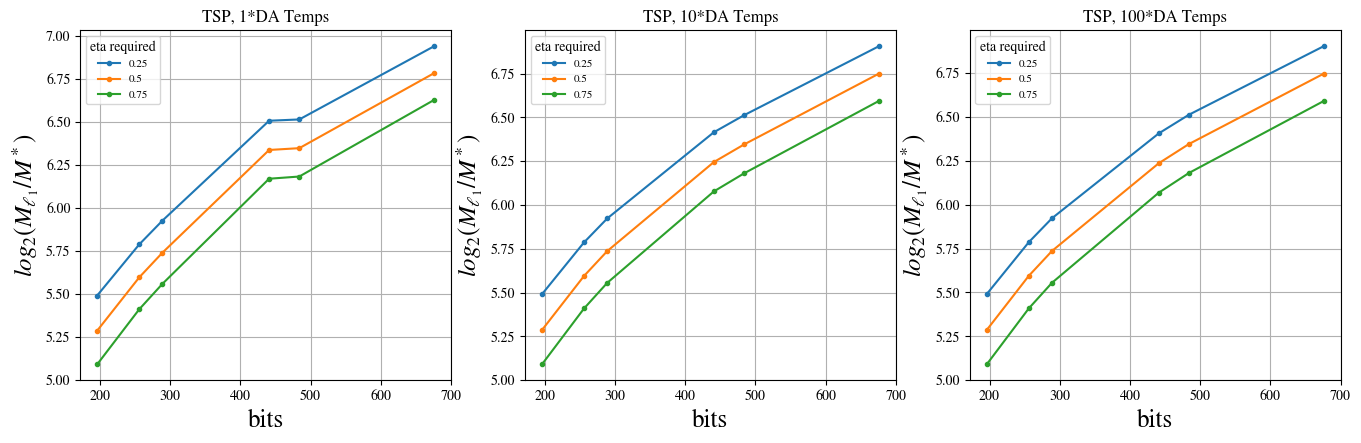

In [20]:
####### NOTE: the current plots are wrong. I.e. log(M_l1/M^*) only really represents the number of iterations saved under the assumptions that they are both larger that M_transition.
####### If this is not the case (like in the current notebook), then what is plotted is not the number of iterations saved



Mstrat = 0

fig = plt.figure(figsize=(22,10))
for temp_idx in range(n_temp_scalers):
    logs = np.mean(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...])  , axis = 1)
    logs_std = np.std(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...]) , axis = 1)
    
    ax = fig.add_subplot(2,4,temp_idx+1)
    ax.set_xlabel('bits', fontsize = 18)
    ax.set_ylabel(r'$log_2( M_{\ell_1} / M^*)$', fontsize = 18)

    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.bits, logs[:, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[0, 0, 0, 0, eta_run_idx]))
        #ax.fill_between(data.bits, logs[:, eta_run_idx] - logs_std[:, eta_run_idx], logs[:, eta_run_idx] + logs_std[:, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
    #ax.set_xscale("log")
    ax.set_title(f"TSP, {data.temperature_scalers[temp_idx]}*DA Temps")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

# Mstrat = 0
# temp_idx = 0
# eta_idx = 0
# for N_idx in [2,3,4]:
#     print(f"For N_idx = {N_idx}, the values for 4 different instances at eta_req = 0.25, temp_scal=1 are:", np.log2(data.M_L1[N_idx, :, temp_idx, Mstrat, eta_idx] / data.M_star[N_idx, :, temp_idx, Mstrat, eta_idx])  )

In [23]:
# Mstrat = 0
# temp_idx = 1

# logs = np.mean(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...])  , axis = 1)
# logs_std = np.std(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...]) , axis = 1)

# fig = plt.figure(figsize=(5,3))
# ax = fig.add_subplot(111)
# ax.set_xlabel('bits', fontsize = 18)
# ax.set_ylabel(r'$log_2( M_{\ell_1} / M^*)$', fontsize = 18)

# for eta_run_idx in np.arange(n_eta_runs):
#     ax.plot(data.bits, logs[:, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]))
#     ax.fill_between(data.bits, logs[:, eta_run_idx] - logs_std[:, eta_run_idx], logs[:, eta_run_idx] + logs_std[:, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
# #ax.set_xscale("log")
# ax.set_title(f"S.A. on MNPP", fontsize = 16)
# ax.legend(title = r"$\eta$", fontsize = 16, loc='best', title_fontsize = 16)
# ax.grid()
# ax.tick_params(axis='both', labelsize=16)
# plt.show()

# # fig.savefig("plots/scale_niters_SA", bbox_inches='tight')
